In [2]:
import pandas as pd 
import numpy as np
from scipy.signal import correlate, correlation_lags
from datetime import datetime
import seaborn as sns
import requests
from pprint import pprint
import copy
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import mxnet as mx
from mxnet import gluon
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%d-%b\n%Y')  
import matplotlib.pyplot as plt
import warnings
#from translate import Translator
warnings.filterwarnings("ignore")

## Getting the data from FOPH
The URLs for downloading the data can be updated daily so that we can download the lates data.

In [3]:
all_cantons = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FL', 'FR', 'GE', 'GL', 'GR', 'JU',
       'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD',
       'VS', 'ZG', 'ZH']

In [4]:
context_url = "https://www.covid19.admin.ch/api/data/context"
context = requests.get(context_url).json()
pprint(context['sources']['individual']['csv']['daily'])

{'cases': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Cases_geoRegion.csv',
 'casesVaccPersons': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Cases_vaccpersons.csv',
 'covidCertificates': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Certificates.csv',
 'death': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Death_geoRegion.csv',
 'deathVaccPersons': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Death_vaccpersons.csv',
 'hosp': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Hosp_geoRegion.csv',
 'hospCapacity': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19HospCapacity_geoRegion.csv',
 'hospVaccPersons': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19Hosp_vaccpersons.csv',
 'intCases': 'https://www.covid19.admin.ch/api/data/20220121-uhudsxzr/sources/COVID19IntCases.csv',
 're': 'ht

In [5]:
def get_cluster_data(curve, cluster):
    
    '''
    This function provide a dataframe with the curve selected in the param curve for each region selected in the 
    param georegion
    
    param curve: string. The following options are accepted: ['cases', 'death',
                                                              'hosp', 'hospCapacity', 
                                                              're', 'test', 'testPcrAntigen', 'virusVariantsWgs']
    param cluster: array with all the geoRegions of interest.
    
    return dataframe
    '''

    
    context_url = "https://www.covid19.admin.ch/api/data/context"
    context = requests.get(context_url).json()
    
    
    if (curve=='hospCapacity'):
        df = pd.read_csv(context['sources']['individual']['csv']['daily'][curve],
                     usecols=['geoRegion','date','ICU_Covid19Patients'])
        df.index = pd.to_datetime(df.date)
        
    else: 
        df = pd.read_csv(context['sources']['individual']['csv']['daily'][curve],
                     usecols=['geoRegion','datum','entries'])
        df.index = pd.to_datetime(df.datum)
    
    # dataframe where will the curve for each region
    
    df_end = pd.DataFrame()
    
    for i in cluster:

        if curve == 'hospCapacity':
            df_end['ICU_patients_'+i] = df.loc[df.geoRegion == i].ICU_Covid19Patients
        else:
            df_end[curve+'_'+i] = df.loc[df.geoRegion == i].entries
    df_end = df_end.resample('D').mean()   
    return df_end

def get_combined_data( data_types, cluster,vaccine = True, smooth = True):
    
    '''
    This function provide a dataframe with the all the curves selected in the param data_types for each region selected in the 
    param georegion
    
    param data_types: array. The following options are accepted: ['cases', 'casesVaccPersons', 'covidCertificates', 'death',
                                                             'deathVaccPersons', 'hosp', 'hospCapacity', 'hospVaccPersons',
                                                             'intCases', 're', 'test', 'testPcrAntigen', 'virusVariantsWgs']
    param cluster: array with all the geoRegions of interest.
    
    return dataframe
    '''

    for i in np.arange(0, len(data_types)):
        
        if i == 0:
            
            df = get_cluster_data(data_types[i], cluster)
            
        else:
            
            df = df.merge(get_cluster_data(data_types[i], cluster), left_index =True, right_index = True)
    
    
    if vaccine == True:
        ## adicionando os dados de vacinação para a suiça disponibilizados pelo 
        ## Our World in Data
        vac = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
        
        # selecionando apenas os dados da suiça 
        vac = vac.loc[vac.iso_code == 'CHE']
        vac.index = pd.to_datetime(vac.date)
        
        vac = vac[['total_vaccinations_per_hundred']]
        
        vac = vac.fillna(0)
        
        if vac.total_vaccinations_per_hundred[-1] == 0:
            vac.total_vaccinations_per_hundred[-1] = vac.total_vaccinations_per_hundred[-2]
    
        
        df['vac_all'] = vac.total_vaccinations_per_hundred
        
    
    # filling the NaN values by zero 
    df = df.fillna(0)
    
    if smooth == True:
        df = df.rolling(window = 7).mean()
        
        df = df.dropna()

        
    return df 

# get_combined_data(['hospCapacity','hosp'], georegion=all_cantons)

In [8]:
df = get_combined_data(['hosp'], ['FR', 'GE', 'GR', 'JU', 'NE', 'TI', 'VD', 'VS'])

del df['vac_all']
df

,hosp_FR,hosp_GE,hosp_GR,hosp_JU,hosp_NE,hosp_TI,hosp_VD,hosp_VS
datum,,,,,,,,
2020-03-01,0.428571,0.428571,0.714286,0.000000,0.142857,1.142857,1.000000,0.285714
2020-03-02,0.857143,0.428571,0.714286,0.000000,0.285714,1.285714,1.000000,0.285714
2020-03-03,0.857143,0.428571,0.857143,0.142857,0.428571,1.714286,1.000000,0.428571
2020-03-04,0.714286,0.571429,0.428571,0.142857,0.285714,2.285714,1.000000,0.571429
2020-03-05,1.000000,0.857143,0.428571,0.142857,0.428571,2.428571,1.714286,0.571429
...,...,...,...,...,...,...,...,...
2022-01-17,3.428571,17.714286,2.142857,0.857143,0.142857,2.857143,5.428571,2.142857
2022-01-18,3.428571,17.714286,1.857143,0.857143,0.142857,2.857143,5.000000,2.571429
2022-01-19,2.857143,17.714286,1.714286,1.000000,0.142857,2.571429,4.714286,2.571429


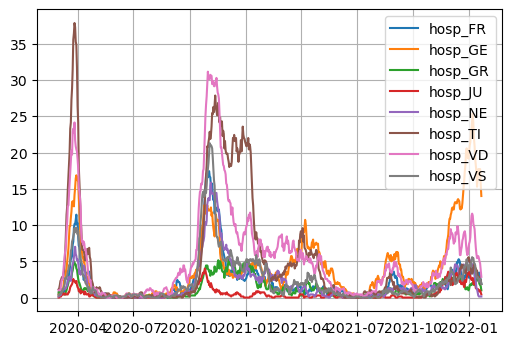

In [9]:
fig, ax  = plt.subplots(dpi =100)

for i in df.columns:
    
    ax.plot(df[i], label = i)
    
ax.legend()
ax.grid()
    
        

#### Gluon Forecast
##### Multivariate

In [10]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
# from gluonts.mx.distribution.poisson import 
from gluonts.model import deepar
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.model.gpvar import GPVAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.evaluation.backtest import backtest_metrics

In [12]:
cluster_canton = ['FR', 'GE', 'GR', 'JU', 'NE', 'TI', 'VD', 'VS']
df = get_combined_data(data_types=['cases', 'hosp', 'test'], 
                       cluster=cluster_canton)

In [13]:
# Creating the multivariate dataset (the series must be on lines)
start = df.index[0]
target = df.T.values
prediction_length = 14
target_dim = target.shape[0]
vnames = df.columns
print(f"Target Dimensions: {target.shape}")
mv_train_ds = ListDataset([{"start": start, "target": target[:,:-prediction_length]}], freq='1D', one_dim_target=False)
mv_test_ds = ListDataset([{"start": start, "target": target[:,-prediction_length:]}], freq='1D', one_dim_target=False)
estimator = DeepVAREstimator(
                            target_dim=target_dim,
                            # distr_output=PoissonOutput(),
                             prediction_length=prediction_length,
                             context_length = 2*prediction_length,
                             freq="D",
                            scaling=True,
                             trainer=Trainer(epochs=15)
                            )
df.describe()

Target Dimensions: (25, 691)


,cases_FR,cases_GE,cases_GR,cases_JU,cases_NE,cases_TI,cases_VD,cases_VS,hosp_FR,hosp_GE,...,hosp_VS,test_FR,test_GE,test_GR,test_JU,test_NE,test_TI,test_VD,test_VS,vac_all
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,111.718627,216.732065,65.977465,27.924333,58.150920,113.301840,289.826132,131.466612,2.227620,4.355799,...,2.387017,767.428571,1907.077734,730.782096,146.627869,431.945421,860.821170,2341.343395,874.454000,43.431635
std,231.019905,422.100764,141.920789,57.833831,117.422202,254.418814,572.322655,278.989447,3.077846,4.816560,...,3.472989,622.232508,1447.016577,837.895245,132.729812,378.994271,771.164953,1732.233489,731.932729,55.858506
min,0.285714,0.714286,0.000000,0.000000,0.142857,0.142857,0.142857,0.285714,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.928571,39.785714,4.642857,1.714286,4.642857,6.000000,41.000000,10.285714,0.428571,0.857143,...,0.285714,329.428571,735.857143,164.500000,59.857143,170.714286,254.857143,1130.785714,308.000000,0.000000
50%,47.142857,104.000000,25.142857,10.285714,25.857143,35.000000,131.857143,52.857143,1.142857,2.857143,...,1.000000,708.285714,1899.571429,495.857143,130.285714,394.428571,786.285714,2247.000000,840.000000,4.827143
75%,76.214286,155.571429,62.071429,22.357143,47.000000,88.857143,216.642857,100.571429,2.857143,5.428571,...,3.071429,1015.785714,2419.071429,854.071429,176.857143,575.857143,1172.142857,3018.071429,1191.571429,102.977857
max,1432.142857,2600.428571,1027.714286,382.000000,813.857143,1540.285714,3656.857143,1765.142857,17.428571,25.428571,...,21.285714,3441.428571,7111.571429,4867.714286,809.857143,2273.000000,4098.857143,9048.714286,4037.428571,170.355714


In [15]:
%%time
mv_predictor = estimator.train(mv_train_ds)

100%|█████████| 50/50 [00:02<00:00, 19.09it/s, epoch=15/15, avg_epoch_loss=84.6]

CPU times: user 40.4 s, sys: 254 ms, total: 40.7 s
Wall time: 40 s


In [16]:
agg_metrics, _ = backtest_metrics(
        test_dataset=mv_test_ds,
        predictor=mv_predictor,
        evaluator=MultivariateEvaluator(
            quantiles=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
        ))
print(agg_metrics)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.94it/s]
Running evaluation: 1it [00:00, 22.54it/s]
Running evaluation: 1it [00:00, 213.68it/s]
Running evaluation: 1it [00:00, 203.99it/s]
Running evaluation: 1it [00:00, 217.40it/s]
Running evaluation: 1it [00:00, 183.01it/s]
Running evaluation: 1it [00:00, 218.29it/s]
Running evaluation: 1it [00:00, 211.60it/s]
Running evaluation: 1it [00:00, 195.69it/s]
Running evaluation: 1it [00:00, 209.78it/s]
Running evaluation: 1it [00:00, 161.94it/s]
Running evaluation: 1it [00:00, 220.83it/s]
Running evaluation: 1it [00:00, 218.00it/s]
Running evaluation: 1it [00:00, 221.82it/s]
Running evaluation: 1it [00:00, 215.48it/s]
Running evaluation: 1it [00:00, 194.48it/s]
Running evaluation: 1it [00:00, 205.85it/s]
Running evaluation: 1it [00:00, 158.05it/s]
Running evaluation: 1it [00:00, 226.71it/s]
Running evaluation: 1it [00:00, 192.42it/s]
Running evaluation: 1it [00:00, 207.76it/s]
Running evaluation: 1it [00:00, 230.52it

{'0_MSE': 1802945.5714285714, '0_abs_error': 18789.859375, '0_abs_target_sum': 18789.859375, '0_abs_target_mean': 1342.1328125, '0_seasonal_error': nan, '0_MASE': nan, '0_MAPE': 1.0, '0_sMAPE': 2.0, '0_MSIS': nan, '0_QuantileLoss[0.1]': 3757.9714355468755, '0_Coverage[0.1]': 0.0, '0_QuantileLoss[0.2]': 7515.942871093751, '0_Coverage[0.2]': 0.0, '0_QuantileLoss[0.3]': 11273.914306640627, '0_Coverage[0.3]': 0.0, '0_QuantileLoss[0.4]': 15031.885742187502, '0_Coverage[0.4]': 0.0, '0_QuantileLoss[0.5]': 18789.857177734375, '0_Coverage[0.5]': 0.0, '0_QuantileLoss[0.6]': 22547.828613281254, '0_Coverage[0.6]': 0.0, '0_QuantileLoss[0.7]': 26305.80004882812, '0_Coverage[0.7]': 0.0, '0_QuantileLoss[0.8]': 30063.771484375004, '0_Coverage[0.8]': 0.0, '0_QuantileLoss[0.9]': 33821.742919921875, '0_Coverage[0.9]': 0.0, '0_RMSE': 1342.7380874275411, '0_NRMSE': 1.0004509799044505, '0_ND': 1.0, '0_wQuantileLoss[0.1]': 0.19999997661221855, '0_wQuantileLoss[0.2]': 0.3999999532244371, '0_wQuantileLoss[0.3]'

(100, 14, 25)


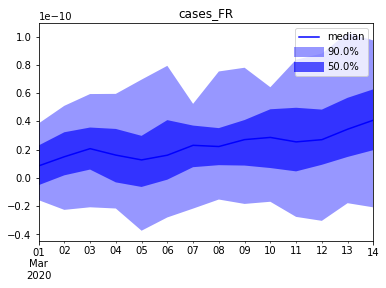

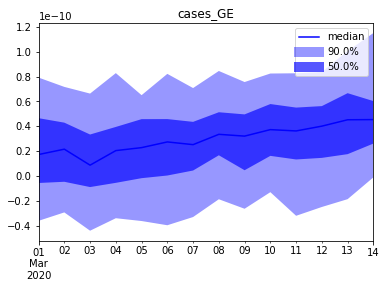

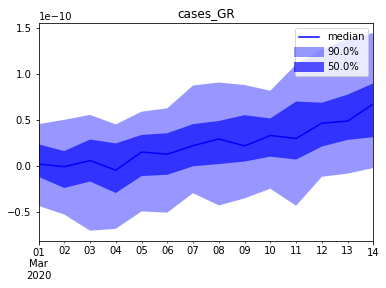

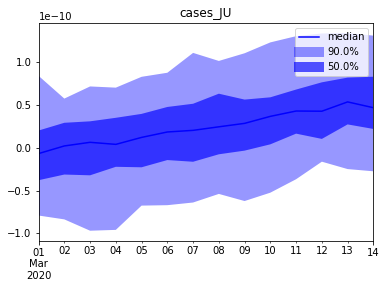

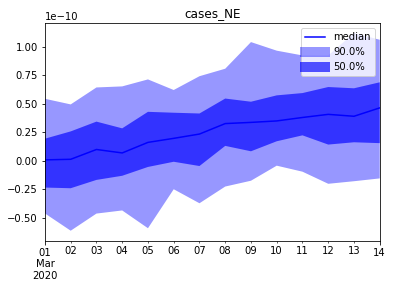

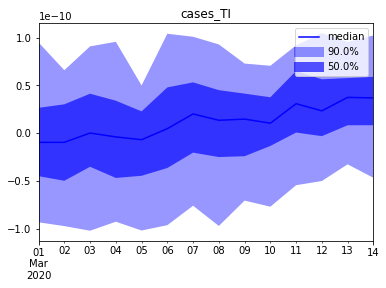

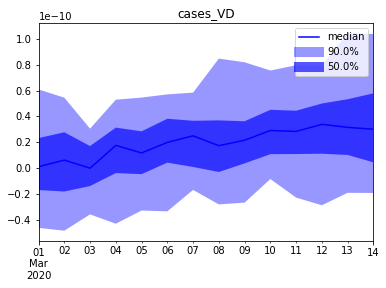

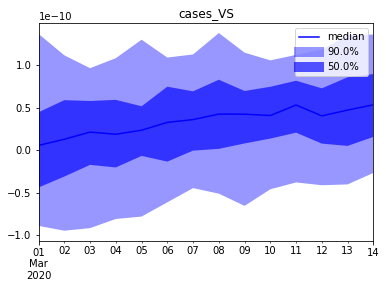

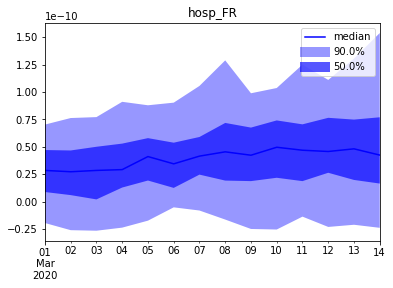

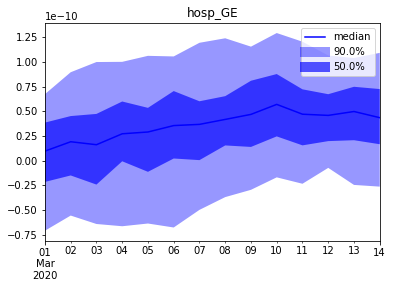

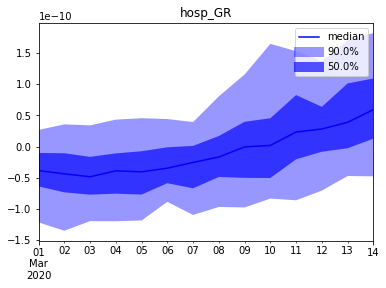

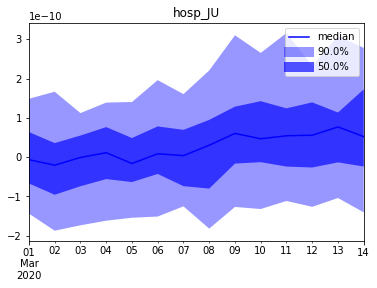

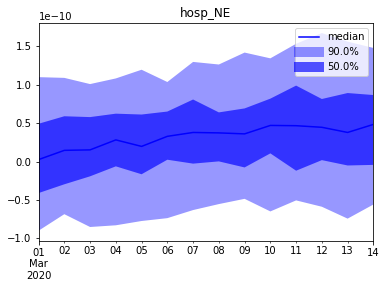

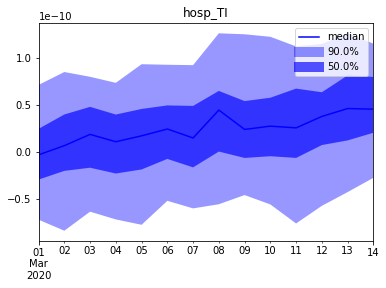

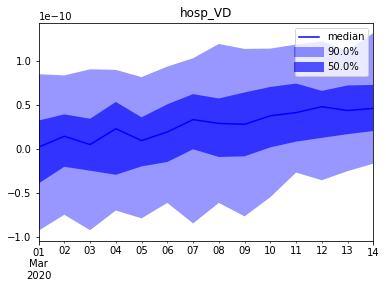

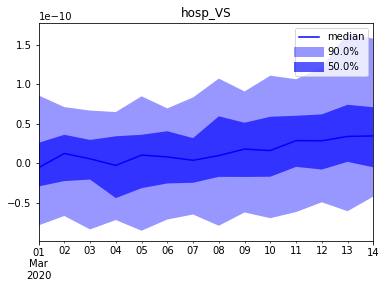

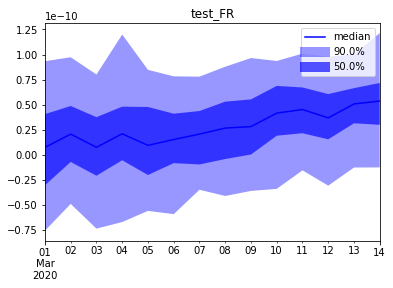

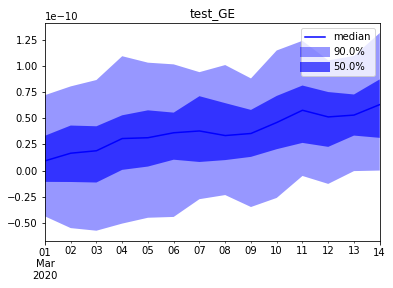

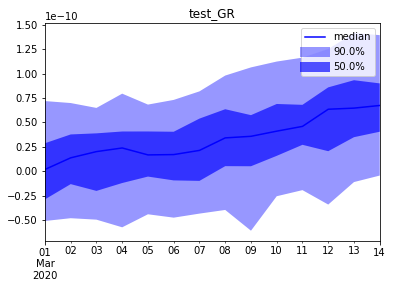

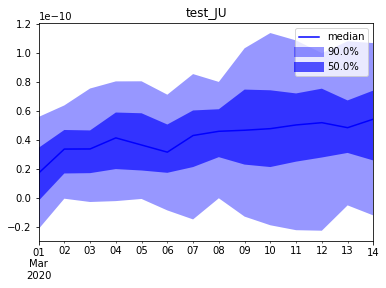

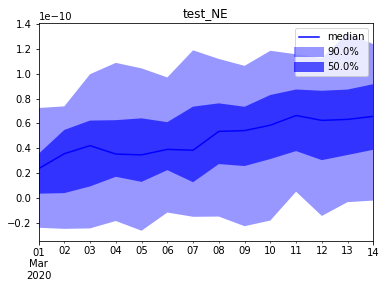

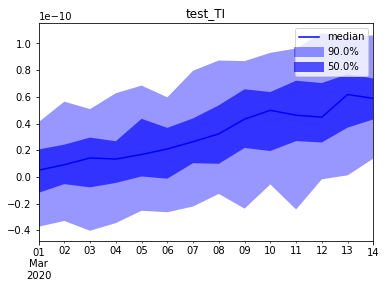

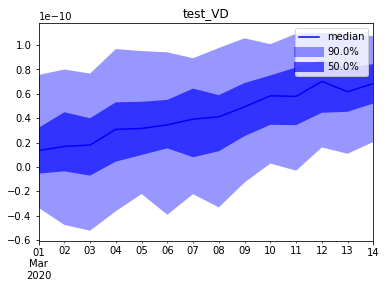

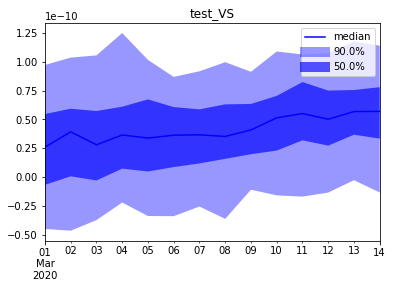

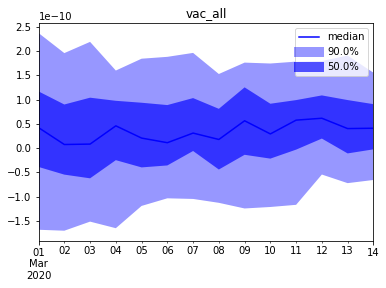

In [19]:
# from gluonts.evaluation.backtest import make_evaluation_predictions

def descaling(original, forecast_obj):
    rng = original.max()-original.min()
    forecast_obj.samples = (forecast_obj.samples*rng)+original.mean()
    return forecast_obj

forecast_it, ts_it = make_evaluation_predictions(
    dataset=mv_test_ds,
    predictor=mv_predictor,
    num_samples=100,
)
forecasts = list(forecast_it)
tss = list(ts_it)

print(forecasts[0].samples.shape)
forecast = forecasts[0]

for i in range(target_dim):
    f = forecast.copy_dim(i)
    # f = descaling(df[vnames[i]],f)
    f.plot()
    plt.title(vnames[i])
    plt.legend()
    plt.show()
# forecast.copy_dim(0)